In [2]:
#from utils.dataset import TrajectCR_Dataset

In [3]:
#from utils.preprocess import sliding_windows, load_power_shortage

In [4]:
from utils.solution import calculate_offline_optimal


In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

from utils.preprocess import sliding_windows, load_power_shortage
from utils.loss import object_loss_cost, object_loss_cr
from utils.model import LSTM_unroll, LSTM_unroll_dynamic
from utils.dataset import TrajectCR_Dataset
from tqdm import tqdm
import json 
import argparse

from utils.solution import calculate_offline_optimal
from train_unroll_batch import single_experiment, train_cr
from utils.traincrs import train_cr_vals_dynamic, train_cr_vals



In [5]:
from train_unroll_batch import single_experiment, train_cr

In [6]:
from utils.traincrs import train_cr_vals_dynamic, train_cr_vals

In [5]:
import tensorboard as tb

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


In [7]:
#from utils.model import LSTM_unroll_dynamic

In [49]:
epoch_constant = 25
uu = {}

In [4]:


# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 1
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   1.000   0.500
Calculating Offline Optimal values ...


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]

Finished Training


In [17]:
#experiment = tb.data.experimental.ExperimentFromDev('./ec_l2o_log/mtl_0.50')
#df = experiment.get_scalars()

In [13]:
event_acc = EventAccumulator('./ec_l2o_log/mtl_0.50')
event_acc.Reload()
event_acc.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['Loss_train/no_calib',
  'Loss_train/with_calib',
  'Loss_train/overall',
  'Loss_val/no_calib',
  'Loss_val/with_calib'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [24]:
pd_1_1_1_train = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
pd_1_1_1_train_calib = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
pd_1_1_1_train_merge = pd_1_1_1_train.merge(pd_1_1_1_train_calib, left_on='step', right_on='step', suffixes=('','train_calib'))


In [ ]:
pd_1_1_1_train_merge.plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

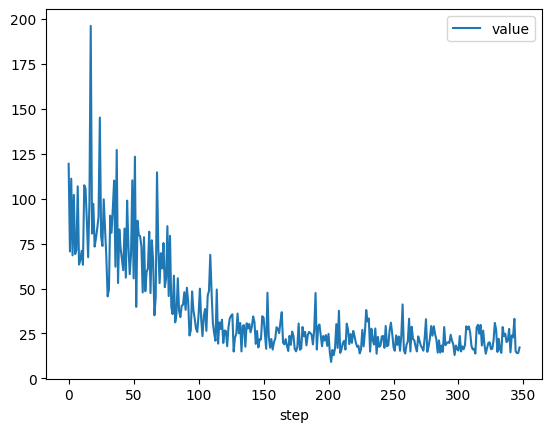

In [26]:
pd_1_1_1_train.plot('step', 'value')

<AxesSubplot:xlabel='step'>

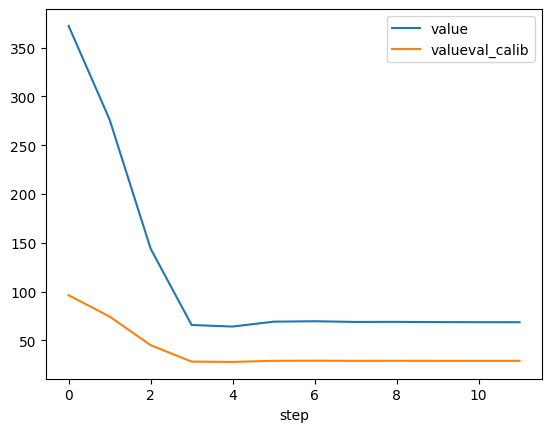

In [28]:
pd_1_1_1_val = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
pd_1_1_1_val_calib = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
pd_1_1_1_val_merge = pd_1_1_1_val.merge(pd_1_1_1_val_calib, left_on='step', right_on='step', suffixes=('','val_calib'))
pd_1_1_1_val_merge.plot('step', ['value', 'valueval_calib'])

In [70]:
uu = {}

In [71]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.000   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:32<00:00,  3.68s/it]

Finished Training


In [72]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['Loss_train/no_calib',
  'Loss_train/with_calib',
  'Loss_train/overall',
  'Loss_val/no_calib',
  'Loss_val/with_calib'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [73]:
t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

<AxesSubplot:xlabel='step'>

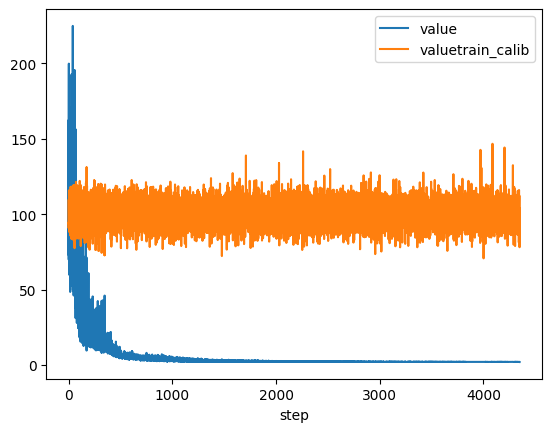

In [74]:
uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

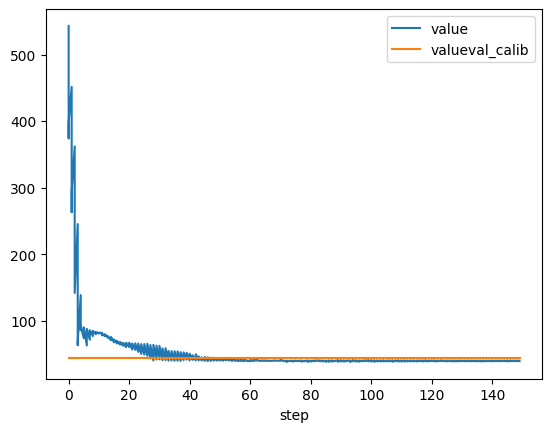

In [75]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [76]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.1
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.100   0.500
Calculating Offline Optimal values ...


  0%|          | 0/1416 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:34<00:00,  3.77s/it]

Finished Training


In [77]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['Loss_train/no_calib',
  'Loss_train/with_calib',
  'Loss_train/overall',
  'Loss_val/no_calib',
  'Loss_val/with_calib'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

<AxesSubplot:xlabel='step'>

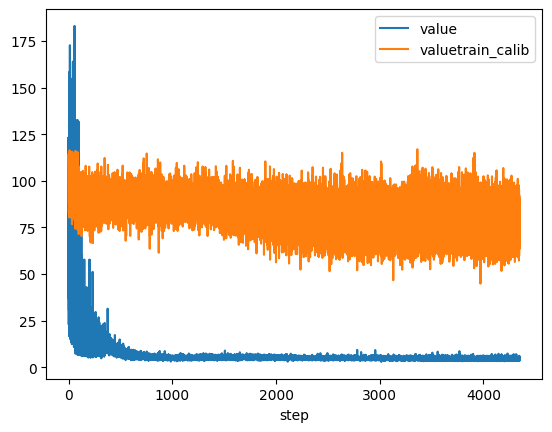

In [78]:
t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])



<AxesSubplot:xlabel='step'>

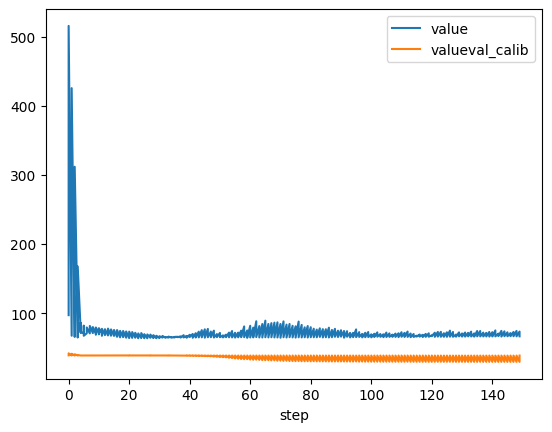

In [79]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [80]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.2
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.200   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:32<00:00,  3.69s/it]

Finished Training


<AxesSubplot:xlabel='step'>

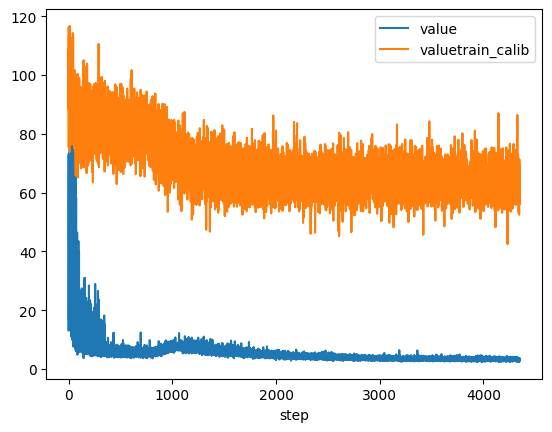

In [81]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])


<AxesSubplot:xlabel='step'>

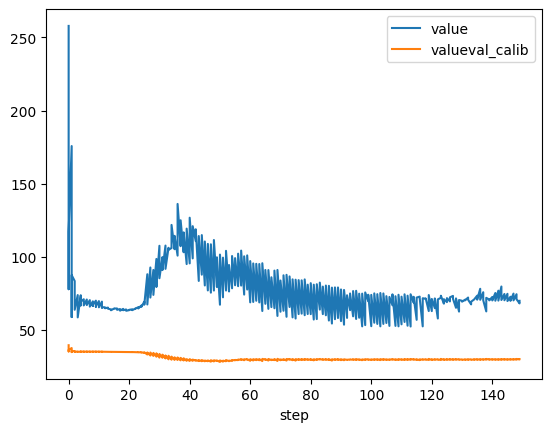

In [82]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [83]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.3
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.300   0.500
Calculating Offline Optimal values ...


  0%|          | 0/1416 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:34<00:00,  3.76s/it]

Finished Training


<AxesSubplot:xlabel='step'>

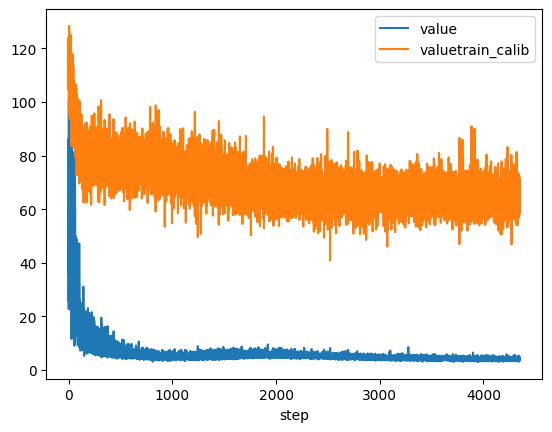

In [84]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])


<AxesSubplot:xlabel='step'>

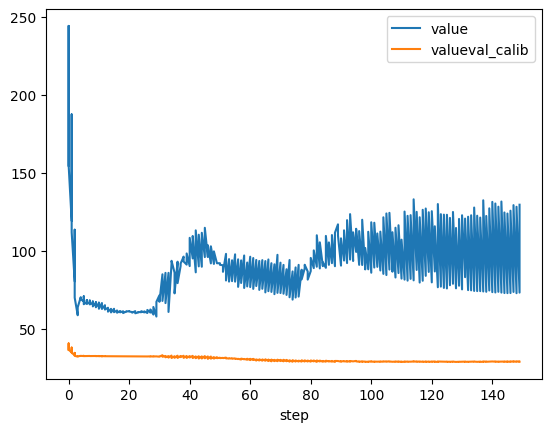

In [85]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [86]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.4
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.400   0.500
Calculating Offline Optimal values ...


  0%|          | 0/1416 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:32<00:00,  3.72s/it]

Finished Training


<AxesSubplot:xlabel='step'>

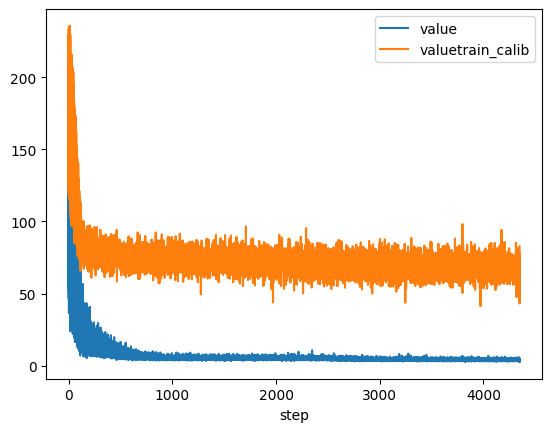

In [87]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

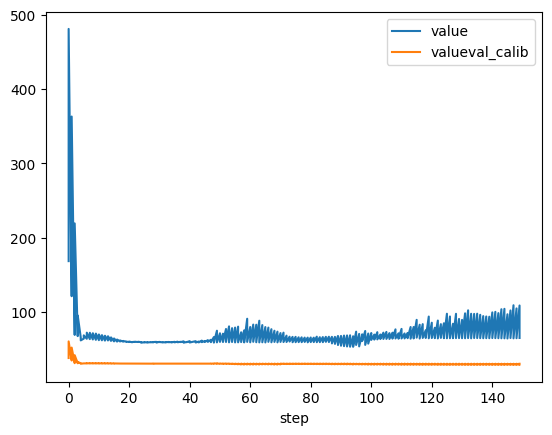

In [88]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [89]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.5
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.500   0.500
Calculating Offline Optimal values ...


  0%|          | 0/1416 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:30<00:00,  3.63s/it]

Finished Training


<AxesSubplot:xlabel='step'>

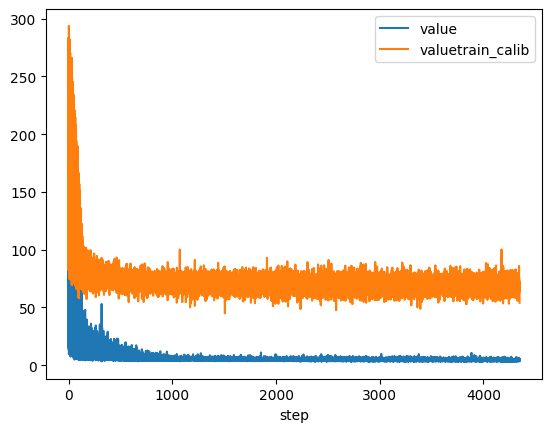

In [90]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

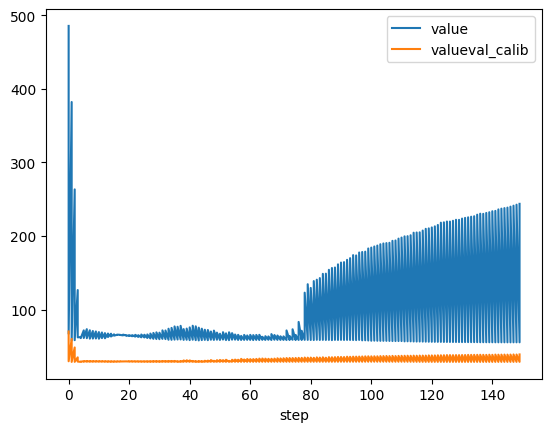

In [91]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [92]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.6
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.600   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:30<00:00,  3.61s/it]

Finished Training


<AxesSubplot:xlabel='step'>

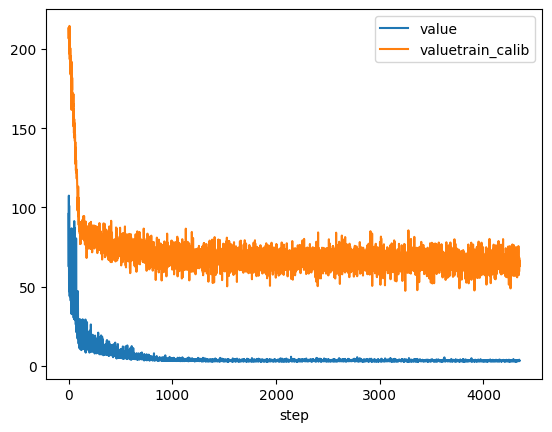

In [93]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

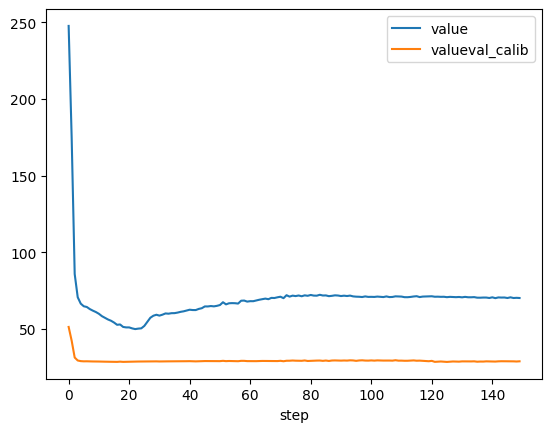

In [94]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [95]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.7
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.700   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:30<00:00,  3.63s/it]

Finished Training


<AxesSubplot:xlabel='step'>

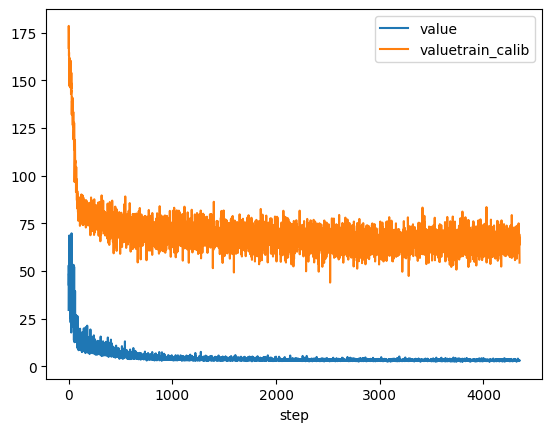

In [96]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

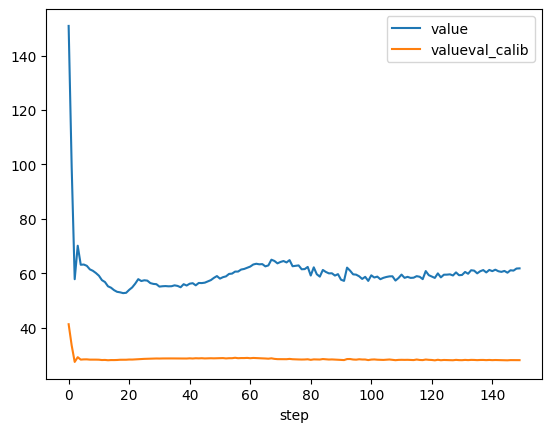

In [97]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [98]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.8
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.800   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:34<00:00,  3.76s/it]

Finished Training


<AxesSubplot:xlabel='step'>

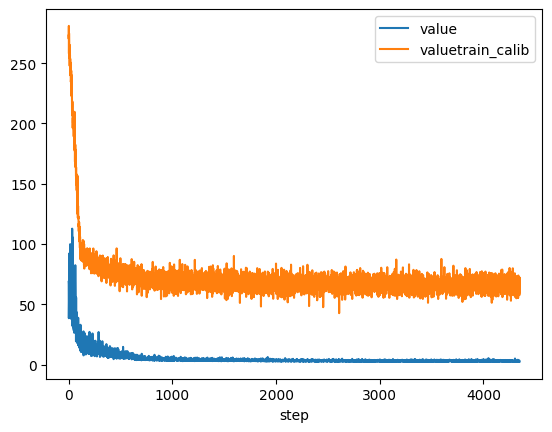

In [99]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

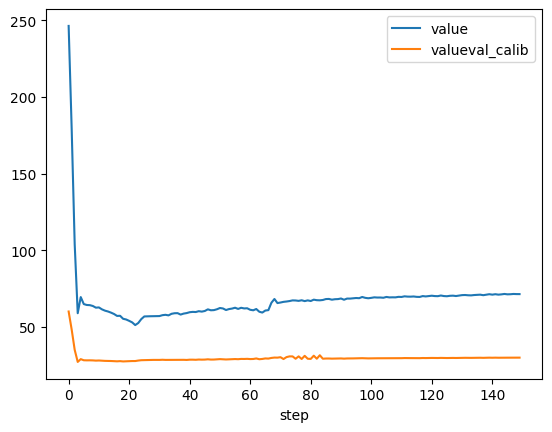

In [100]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [101]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 0.9
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   0.900   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:31<00:00,  3.66s/it]

Finished Training


<AxesSubplot:xlabel='step'>

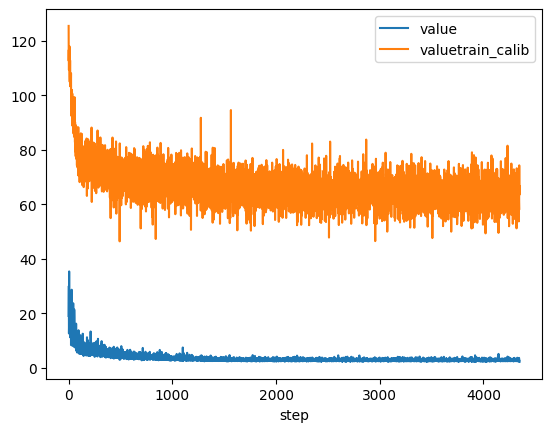

In [102]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

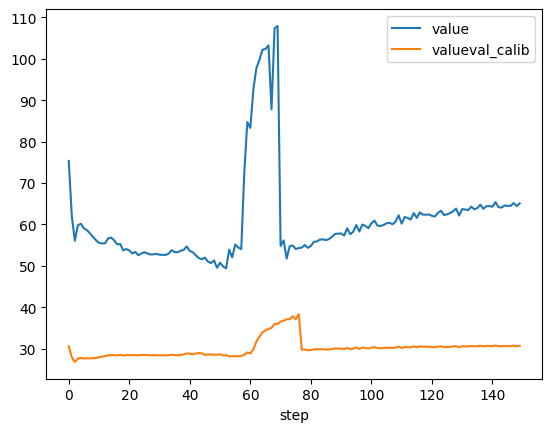

In [103]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [104]:
# Problem definition
w = 10
l_1 = 1
l_2 = 1
l_3 = 1
min_cr = 2

# Traing parameters
epoch_num = epoch_constant
lr_list = [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]
batch_size = 50

# Experiment parameters
base_log_dir = "./ec_l2o_log/"
mtl_list = np.array([0.5])

for mtl_weight in mtl_list:
    writer_path = f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/'
    writer = SummaryWriter(writer_path)
    single_experiment(writer, w, l_1, l_2, l_3, mtl_weight, min_cr, 
                epoch_num, lr_list, batch_size, mute=False)

print('Finished Training')

Parameters
     w     l_1     l_2     l_3     mtl     
  10.000   1.000   1.000   1.000   0.500
Calculating Offline Optimal values ...


100%|██████████| 25/25 [01:32<00:00,  3.69s/it]

Finished Training


<AxesSubplot:xlabel='step'>

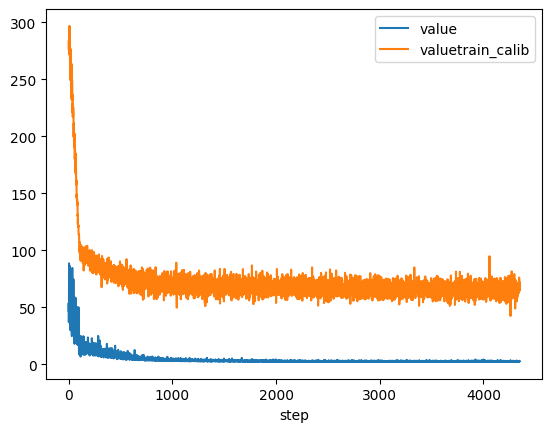

In [105]:
event_acc = EventAccumulator(f'{base_log_dir}/mtl_{mtl_weight}_{l_1}_{l_2}_{l_3}/')
event_acc.Reload()
event_acc.Tags()

t1 = f'pd_{l_1}_{l_2}_{l_3}_train'
t2 = f'pd_{l_1}_{l_2}_{l_3}_train_calib'
t3 = f'pd_{l_1}_{l_2}_{l_3}_train_merge'

uu[t1] = pd.DataFrame(event_acc.Scalars('Loss_train/no_calib'))
uu[t2] = pd.DataFrame(event_acc.Scalars('Loss_train/with_calib'))
uu[t3] = uu[t1].merge(uu[t2], left_on='step', right_on='step', suffixes=('','train_calib'))
uu[t3].plot('step', ['value', 'valuetrain_calib'])

<AxesSubplot:xlabel='step'>

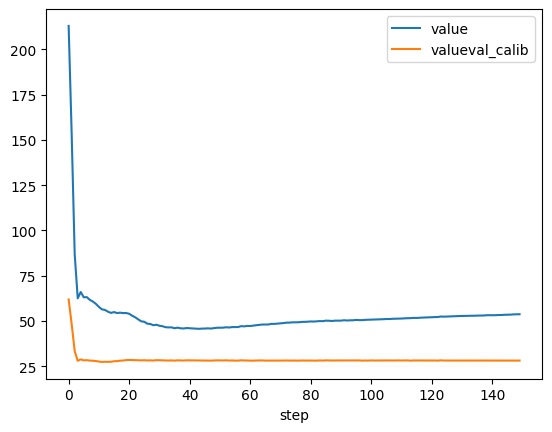

In [106]:
v1 = f'pd_{l_1}_{l_2}_{l_3}_val'
v2 = f'pd_{l_1}_{l_2}_{l_3}_val_calib'
v3 = f'pd_{l_1}_{l_2}_{l_3}_val_merge'

uu[v1] = pd.DataFrame(event_acc.Scalars('Loss_val/no_calib'))
uu[v2] = pd.DataFrame(event_acc.Scalars('Loss_val/with_calib'))
uu[v3] = uu[v1].merge(uu[v2], left_on='step', right_on='step', suffixes=('','val_calib'))
uu[v3].plot('step', ['value', 'valueval_calib'])

In [113]:
pdg = uu[f'pd_{l_1}_{l_2}_{0}_val_calib'].tail(1)
for i in range(1,10,1):
    j = i/10
    pdg = pd.concat([pdg, uu[f'pd_{l_1}_{l_2}_{j}_val_calib'].tail(1)])

In [118]:
xx = list(range(10))
xx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [119]:
pdg['points'] = list(range(10))

<AxesSubplot:xlabel='points'>

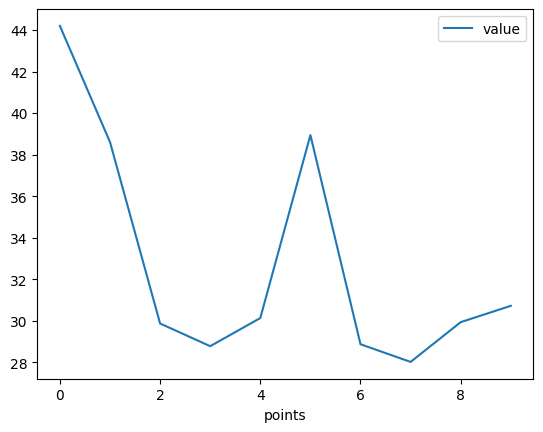

In [120]:
pdg.plot('points', 'value')

In [3]:
config_data = {"epoch_num": 25,
    "lr_list": [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5],
    "batch_size": 50,
    "w": 10.0, 
    "l_1": 1.0,
    "l_2": 0.2317,
    "l_3": 0.1,
    "min_cr":2,
    "mtl_list": [0.0],
    "base_log_dir": "./ec_l2o_log/"}

In [4]:
w = config_data["w"]
l_1 = config_data["l_1"]
l_2 = config_data["l_2"]
l_3 = config_data["l_3"]
min_cr = config_data["min_cr"]

    # Traing parameters
epoch_num = config_data["epoch_num"]
lr_list = config_data["lr_list"]
batch_size = config_data["batch_size"]
    
    # Experiment parameters
base_log_dir = config_data["base_log_dir"]
mtl_list = np.array(config_data["mtl_list"])

In [14]:
mtl_list

array([0.])

In [8]:
csv_file = "data/solar_2015.csv"
df= pd.read_csv(csv_file, header = 2)

In [9]:
data_raw = load_power_shortage(df)
data_raw = data_raw.reshape([-1,1])


In [10]:
n_trian_step=24*60
n_val_step=24*30

In [32]:
24*60 + 24*60 + 24*30 + 24*60

5040

In [41]:
data_raw[1:25,0]

array([0.74131224, 0.73870904, 0.7352929 , 0.73196819, 0.72334319,
       0.67799973, 0.57273686, 0.429265  , 0.29971744, 0.22874868,
       0.22247214, 0.2532033 , 0.31431747, 0.4115392 , 0.53195375,
       0.6440564 , 0.71959413, 0.75165585, 0.75553345, 0.74908337,
       0.74148936, 0.73386736, 0.7269514 , 0.72209634])

In [11]:
train_raw=data_raw[:n_trian_step, :]
val_raw=data_raw[n_trian_step:n_trian_step+n_val_step, :]


In [11]:
data_raw.shape

(8760, 1)

In [12]:
test_raw=data_raw[n_trian_step+n_val_step:,:]
test_raw.shape

(6600, 1)

In [13]:
hidden_size = 10
num_classes = 1

input_size = 2 * num_classes
seq_length = 25
num_layers = 3
base_log_dir = "./ec_l2o_log/"

In [14]:
train_seq = sliding_windows(train_raw, seq_length)


In [15]:
csv_file = "data/solar_2015.csv"
mute = True
use_cuda = False
w = 10
min_cr = 2
mtl_weigh = .6
switch_weight = 1
mtl_list = np.array([0.5])

In [16]:
from utils.loss import object_loss_cost, object_loss_cr

In [17]:
#del train_cr_vals
%load_ext autoreload
%autoreload 2
#del train_cr_vals
from utils.traincrs import train_cr_vals

In [18]:
m = 2
B = 10
alp = 10

In [19]:
import math

In [3]:
def ltwo(l1, l3,m,alp):
    l2 = (m*l1/(2*B))*(math.sqrt((1+(B/m)*(l3/l1))**2 + 4*B**2/(alp*m)) + 1 - 2/l1 - (B/m)*(l3/l1))
    return l2

In [21]:
ltwo(1,.6,m,alp)

0.2

In [6]:
pureml = {}
pureml["l1"] = 1
pureml["l2"] = 0
pureml["l3"] = 0
pureml["mtl_weight"] = 1
pureml["c"] =1
pureml["traincalib"] = False
pureml["testcalib"] = False
pureml["name"] = "pureml"

In [7]:
robd = {}
robd["l1"] = 1
robd["l2"] = ltwo(1, 0, m, alp)
robd["l3"] = 0
robd["mtl_weight"] = .6
robd["c"] =1
robd["traincalib"] = True
robd["testcalib"] = True
robd["name"] = "robd"

In [8]:
mlrobd = {}
mlrobd["l1"] = 1
mlrobd["l2"] = ltwo(1, .3, m, alp)
mlrobd["l3"] = 0.3
mlrobd["mtl_weight"] = 1
mlrobd["c"] =1
mlrobd["traincalib"] = False
mlrobd["testcalib"] = True
mlrobd["name"] = "mlrobd"

In [9]:
ecl20 = {}
ecl20["l1"] = 1
ecl20["l3"] = 0.5
ecl20["l2"] = ltwo(1, .5, m, alp)
ecl20["mtl_weight"] = 0.6
ecl20["c"] =1
ecl20["traincalib"] = True
ecl20["testcalib"] = True
ecl20["name"] = "ecl20"

In [10]:
ecl20b = {}
ecl20b["l1"] = 1
ecl20b["l3"] = 0.5
ecl20b["l2"] = ltwo(1, .5, m, alp)
ecl20b["mtl_weight"] = 0.2
ecl20b["c"] =1
ecl20b["traincalib"] = True
ecl20b["testcalib"] = True
ecl20b["name"] = "ecl20b"

In [407]:
epoch_num=25

In [10]:
n_iter = 0
n_iter_val = 0
epoch_num = 25
batch_size = 50
#print("Parameters")
#print("     w     l_1     l_2     l_3     mtl     ")
#print("  {:.3f}   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(w, l_1, l_2, l_3, mtl_weight))

hidden_size = 10
num_classes = 1

input_size = 2 * num_classes
seq_length = 25
num_layers = 3

# df_header = pd.read_csv(csv_file, nrows=1) ## general information (e.g. time zone, elevation)
df= pd.read_csv(csv_file, header = 2)

data_raws = load_power_shortage(df)

n_trian_step=24*60
n_val_step=24*30
# n_test_step=24*60

## Splitting training and testing dataset
data_raw = data_raws.reshape([-1,1])
train_raw=data_raw[:n_trian_step, :]
val_raw=data_raw[n_trian_step:n_trian_step+n_val_step, :]

train_seq = sliding_windows(train_raw, seq_length)


traject_dataset_train = TrajectCR_Dataset(train_seq, w, mute=mute)
train_dataloader = DataLoader(traject_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

val_seq = val_raw.reshape([1,-1,1])
val_seq_tensor = torch.from_numpy(val_seq).float()
if use_cuda: val_seq_tensor = val_seq_tensor.cuda()

lstm = LSTM_unroll(num_classes, input_size, hidden_size, num_layers, 
                        seq_length, w, l_1, l_2, l_3)

optimizer = optim.Adam(lstm.parameters(), lr=4e-4)
if use_cuda: lstm = lstm.cuda()
writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
writer = SummaryWriter(writer_path)
#del train_cr
#from train_unroll_batch import train_cr

#train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
#            epoch_num, pureml["c"], min_cr, mtl_weight=pureml["mtl_weight"], mute=mute, l_1=pureml["l1"],l_2=pureml["l2"], l_3=pureml["l3"], calib=pureml["calib"])

train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
            epoch_num, robd["c"], min_cr, mtl_weight=robd["mtl_weight"], mute=mute, l_1=robd["l1"],l_2=robd["l2"], l_3=robd["l3"], calib=robd["calib"])

Calculating Offline Optimal values ...


KeyboardInterrupt: 

In [436]:
val_seq = sliding_windows(val_raw, seq_length)
val_seq.shape
val_action_seq = torch.zeros(val_seq.shape)
val_action_seq.shape

torch.Size([696, 25, 1])

In [438]:
hit_cost = torch.norm(tmval - torch.from_numpy(val_seq).float(), dim=1)
hit_cost = (hit_cost)**2

#switch_diff = action[:,1:,:] - action[:,:-1,:]
switch_cost = torch.norm(tmval[:,1:,:] - tmval[:,:-1,:], dim=1)
switch_cost = (switch_cost)**2

In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

from utils.preprocess import sliding_windows, load_power_shortage
from utils.loss import object_loss_cost, object_loss_cr
from utils.model import LSTM_unroll, LSTM_unroll_dynamic
from utils.dataset import TrajectCR_Dataset
from tqdm import tqdm
import json 
import argparse

from utils.solution import calculate_offline_optimal
from train_unroll_batch import single_experiment, train_cr
from utils.traincrs import train_cr_vals_dynamic, train_cr_vals


random.seed(10)
hidden_size = 10
num_classes = 1

input_size = 2 * num_classes
seq_length = 25
num_layers = 3
base_log_dir = "./ec_l2o_log/"

csv_file = "data/solar_2015.csv"
mute = True
use_cuda = False
w = 10
min_cr = 2
mtl_weigh = .6
switch_weight = 1
mtl_list = np.array([0.5])

m = 2
B = 10
alp = 10

def ltwo(l1, l3,m,alp):
    l2 = (m*l1/(2*B))*(math.sqrt((1+(B/m)*(l3/l1))**2 + 4*B**2/(alp*m)) + 1 - 2/l1 - (B/m)*(l3/l1))
    return l2

def optimal_cost_calc(raw_data, seq_length):
    val_seq = sliding_windows(raw_data, seq_length)

    num_val_seq = val_seq.shape[0]
    optimal_val_cost_array = np.zeros(num_val_seq)
        
    #print("Calculating Offline Optimal values ...")
    #if mute:
    seq_val_list = range(num_val_seq)
    #else:
    #    seq_list = tqdm(range(num_seq))
    for i in seq_val_list:
        sample_seq = val_seq[i,:,:]
        _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
        optimal_val_cost_array[i] = optimal_cost

    return optimal_val_cost_array



pureml = {}
pureml["l1"] = 1
pureml["l2"] = 0
pureml["l3"] = 0
pureml["mtl_weight"] = 1
pureml["c"] =1
pureml["traincalib"] = False
pureml["testcalib"] = False
pureml["name"] = "pureml"

robd = {}
robd["l1"] = 1
robd["l2"] = ltwo(1, 0, m, alp)
robd["l3"] = 0
robd["mtl_weight"] = .6
robd["c"] =1
robd["traincalib"] = True
robd["testcalib"] = True
robd["name"] = "robd"


mlrobd = {}
mlrobd["l1"] = 1
mlrobd["l2"] = ltwo(1, 0, m, alp)  #changed l3 to 0 different from paper to check
mlrobd["l3"] = 0   #should robd have non-zero l3
mlrobd["mtl_weight"] = 1
mlrobd["c"] =1
mlrobd["traincalib"] = False
mlrobd["testcalib"] = True
mlrobd["name"] = "mlrobd"

ml2robd = {}
ml2robd["l1"] = 1
ml2robd["l2"] = ltwo(1, .3, m, alp)  
ml2robd["l3"] = .3   
ml2robd["mtl_weight"] = 1
ml2robd["c"] =1
ml2robd["traincalib"] = False
ml2robd["testcalib"] = True
ml2robd["name"] = "ml2robd"


ecl20 = {}
ecl20["l1"] = 1
ecl20["l3"] = 0.5
ecl20["l2"] = ltwo(1, .5, m, alp)
ecl20["mtl_weight"] = 0.6
ecl20["c"] =1
ecl20["traincalib"] = True
ecl20["testcalib"] = True
ecl20["name"] = "ecl20"

ecl20b = {}
ecl20b["l1"] = 1
ecl20b["l3"] = 0.5
ecl20b["l2"] = ltwo(1, .5, m, alp)
ecl20b["mtl_weight"] = 0.2
ecl20b["c"] =1
ecl20b["traincalib"] = True
ecl20b["testcalib"] = True
ecl20b["name"] = "ecl20b"



In [2]:

def replication(input_dict, csv_file, epoch_number=25, lr=4e-4):
    
    random.seed(10)
    np.random.seed(10)
    torch.manual_seed(10)
    l_1 = input_dict["l1"]
    l_2 = input_dict["l2"]
    l_3 = input_dict["l3"]
    n_iter = 0
    n_iter_val = 0
    epoch_num = epoch_number
    batch_size = 20 #change from 50 to 5 depending on debudding
    #print("Parameters")
    #print("     w     l_1     l_2     l_3     mtl     ")
    #print("  {:.3f}   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(w, l_1, l_2, l_3, mtl_weight))

    hidden_size = 10
    num_classes = 1

    input_size = 2 * num_classes
    seq_length = 25 #25
    num_layers = 3

    
    mtl_weight = input_dict["mtl_weight"]

    # df_header = pd.read_csv(csv_file, nrows=1) ## general information (e.g. time zone, elevation)
    df= pd.read_csv(csv_file, header = 2)

    data_raws = load_power_shortage(df)

    n_trian_step= 24*60 #24*60   #orginally 24*60 change for debugging to 10
    n_val_step= 24*30 #  24*30    #originally 24*30 change for debugging to 10
    n_test_step= 24*60 # 24*60
    offset = 0 #Used for debugging to get zeros in input value

    ## Splitting training and testing dataset
    data_raw = data_raws.reshape([-1,1])
    train_raw=data_raw[offset:n_trian_step+offset, :]
    val_raw=data_raw[n_trian_step+offset:n_trian_step+n_val_step+offset, :]
    test_raw = data_raw[n_trian_step + n_val_step+offset:n_trian_step+n_val_step + n_test_step+offset,:]
    #print(f'train raw is {train_raw.size}') 
    train_seq = sliding_windows(train_raw, seq_length)
    val_seq = sliding_windows(val_raw, seq_length)
    temp_seq = sliding_windows(test_raw, seq_length)
    #temp_seq = sliding_windows(temp_raw, seq_length)
    bsize = temp_seq.shape[0]
    #print(f'bsize is {bsize}')

    op_val_cost_array = optimal_cost_calc(val_raw, seq_length)
    op_temp_cost_array = optimal_cost_calc(test_raw, seq_length)

    #print(f'train_seq is {train_seq.size}')
    traject_dataset_train = TrajectCR_Dataset(train_seq, w, mute=mute)
    train_dataloader = DataLoader(traject_dataset_train, batch_size=batch_size, shuffle=False, num_workers=4)

    traject_dataset_val = TrajectCR_Dataset(val_seq, w, mute=mute)
    val_dataloader = DataLoader(traject_dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

    traject_dataset_temp = TrajectCR_Dataset(temp_seq, w, mute=mute)
    temp_dataloader = DataLoader(traject_dataset_temp, batch_size=bsize, shuffle=False, num_workers=4)

    val_seq = val_raw.reshape([1,-1,1])
    val_seq_tensor = torch.from_numpy(val_seq).float()
    if use_cuda: val_seq_tensor = val_seq_tensor.cuda()

    


    lstm = LSTM_unroll(num_classes, input_size, hidden_size, num_layers, 
                        seq_length, w, l_1, l_2, l_3)

    optimizer = optim.Adam(lstm.parameters(), lr=lr)
    if use_cuda: lstm = lstm.cuda()
    writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
    writer = SummaryWriter(writer_path)
    #del train_cr
    #from train_unroll_batch import train_cr

    #train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
    #            epoch_num, pureml["c"], min_cr, mtl_weight=pureml["mtl_weight"], mute=mute, l_1=pureml["l1"],l_2=pureml["l2"], l_3=pureml["l3"], calib=pureml["calib"])

    train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
            epoch_num, input_dict["c"], min_cr, mtl_weight=input_dict["mtl_weight"], mute=mute, l_1=input_dict["l1"],l_2=input_dict["l2"], l_3=input_dict["l3"], calib=input_dict["traincalib"])
    temp_seq = sliding_windows(test_raw, seq_length)
    #temp_seq.shape
    temp_action_seq = torch.zeros(temp_seq.shape)
    temp_action_seq.shape
    lstm.eval()
    tmval = lstm(torch.from_numpy(temp_seq).float(), mode="val", calib=input_dict["testcalib"])
    #print(tmval.shape)
    #print(torch.max(tmval))
    hit_cost = torch.norm(tmval - torch.from_numpy(temp_seq).float(), dim=1)
    hit_cost = (1/2)*(hit_cost)**2
    #print(torch.max(hit_cost))

    #switch_diff = action[:,1:,:] - action[:,:-1,:]
    switch_cost = torch.norm(tmval[:,1:,:] - tmval[:,:-1,:], dim=1)
    switch_cost = (10/2)*(switch_cost)**2
    #print(switch_cost.shape)
    val_cost_norm = hit_cost + switch_cost
    norm_cost = torch.div(val_cost_norm, torch.from_numpy(op_temp_cost_array).unsqueeze(1))
    #print(torch.max(norm_cost))
    average_cost_value = torch.mean(norm_cost).item()
    cr_value = torch.max(norm_cost).item()
    return [average_cost_value, cr_value]


In [697]:
df = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

In [699]:
epoch_num = 75
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        df.loc[len(df.index)] = [li, epoch_num, i["name"], avg, cr]
        


Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.9724343955869221 and cr is 4.885475946898804 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd average is 0.8155161788125346 and cr is 1.2442886990017246 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
ecl20 average is 0.9013370678851014 and cr is 2.9132138424314946 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.995265912382489 and cr is 8.41984585748543 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd average

In [15]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import math
import random

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

from utils.preprocess import sliding_windows, load_power_shortage
from utils.loss import object_loss_cost, object_loss_cr
from utils.model import LSTM_unroll, LSTM_unroll_dynamic
from utils.dataset import TrajectCR_Dataset
from tqdm import tqdm
import json 
import argparse

from utils.solution import calculate_offline_optimal
from train_unroll_batch import single_experiment, train_cr
from utils.traincrs import train_cr_vals_dynamic, train_cr_vals


random.seed(10)
hidden_size = 10
num_classes = 1

input_size = 2 * num_classes
seq_length = 25
num_layers = 3
base_log_dir = "./ec_l2o_log/"

csv_file = "data/solar_2015.csv"
mute = True
use_cuda = False
w = 10
min_cr = 2
mtl_weigh = .6
switch_weight = 1
mtl_list = np.array([0.5])

m = 2
B = 10
alp = 10

def ltwo(l1, l3,m,alp):
    l2 = (m*l1/(2*B))*(math.sqrt((1+(B/m)*(l3/l1))**2 + 4*B**2/(alp*m)) + 1 - 2/l1 - (B/m)*(l3/l1))
    return l2

def optimal_cost_calc(raw_data, seq_length):
    val_seq = sliding_windows(raw_data, seq_length)

    num_val_seq = val_seq.shape[0]
    optimal_val_cost_array = np.zeros(num_val_seq)
        
    #print("Calculating Offline Optimal values ...")
    #if mute:
    seq_val_list = range(num_val_seq)
    #else:
    #    seq_list = tqdm(range(num_seq))
    for i in seq_val_list:
        sample_seq = val_seq[i,:,:]
        _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
        optimal_val_cost_array[i] = optimal_cost

    return optimal_val_cost_array



pureml = {}
pureml["l1"] = 1
pureml["l2"] = 0
pureml["l3"] = 0
pureml["mtl_weight"] = 1
pureml["c"] =1
pureml["traincalib"] = False
pureml["testcalib"] = False
pureml["name"] = "pureml"

robd = {}
robd["l1"] = 1
robd["l2"] = ltwo(1, 0, m, alp)
robd["l3"] = 0
robd["mtl_weight"] = .6
robd["c"] =1
robd["traincalib"] = True
robd["testcalib"] = True
robd["name"] = "robd"


mlrobd = {}
mlrobd["l1"] = 1
mlrobd["l2"] = ltwo(1, .3, m, alp)
mlrobd["l3"] = 0.3
mlrobd["mtl_weight"] = 1
mlrobd["c"] =1
mlrobd["traincalib"] = False
mlrobd["testcalib"] = True
mlrobd["name"] = "mlrobd"

ecl20 = {}
ecl20["l1"] = 1
ecl20["l3"] = 0.5
ecl20["l2"] = ltwo(1, .5, m, alp)
ecl20["mtl_weight"] = 0.6
ecl20["c"] =1
ecl20["traincalib"] = True
ecl20["testcalib"] = True
ecl20["name"] = "ecl20"

ecl20b = {}
ecl20b["l1"] = 1
ecl20b["l3"] = 0.5
ecl20b["l2"] = ltwo(1, .5, m, alp)
ecl20b["mtl_weight"] = 0.2
ecl20b["c"] =1
ecl20b["traincalib"] = True
ecl20b["testcalib"] = True
ecl20b["name"] = "ecl20b"



In [3]:

hidden_size = 10
num_classes = 1

input_size = 2 * num_classes
seq_length = 25
num_layers = 3
base_log_dir = "./ec_l2o_log/"

csv_file = "data/solar_2015.csv"
mute = True
use_cuda = False
w = 10
min_cr = 2
mtl_weigh = .6
switch_weight = 1
mtl_list = np.array([0.5])

m = 2
B = 10
alp = 10

def ltwo(l1, l3,m,alp):
    l2 = (m*l1/(2*B))*(math.sqrt((1+(B/m)*(l3/l1))**2 + 4*B**2/(alp*m)) + 1 - 2/l1 - (B/m)*(l3/l1))
    return l2

In [4]:
def optimal_cost_calc(raw_data, seq_length):
    val_seq = sliding_windows(raw_data, seq_length)

    num_val_seq = val_seq.shape[0]
    optimal_val_cost_array = np.zeros(num_val_seq)
        
    #print("Calculating Offline Optimal values ...")
    #if mute:
    seq_val_list = range(num_val_seq)
    #else:
    #    seq_list = tqdm(range(num_seq))
    for i in seq_val_list:
        sample_seq = val_seq[i,:,:]
        _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
        optimal_val_cost_array[i] = optimal_cost

    return optimal_val_cost_array


In [5]:
'''
def optimal_cost_calc(raw_data, seq_length):
    val_seq = sliding_windows(val_raw, seq_length)

    num_val_seq = val_seq.shape[0]
    optimal_val_cost_array = np.zeros(num_val_seq)
        
    #print("Calculating Offline Optimal values ...")
    #if mute:
    seq_val_list = range(num_val_seq)
    #else:
    #    seq_list = tqdm(range(num_seq))
    for i in seq_val_list:
        sample_seq = val_seq[i,:,:]
        _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
        optimal_val_cost_array[i] = optimal_cost

    return optimal_val_cost_array

val_seq = sliding_windows(val_raw, seq_length)

num_val_seq = val_seq.shape[0]
optimal_val_cost_array = np.zeros(num_val_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_val_list = range(num_val_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_val_list:
    sample_seq = val_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_val_cost_array[i] = optimal_cost


train_seq = sliding_windows(train_raw, seq_length)
num_test_seq = train_seq.shape[0]
optimal_train_cost_array = np.zeros(num_test_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_test_list = range(num_test_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_test_list:
    sample_seq = train_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_train_cost_array[i] = optimal_cost


test_seq = sliding_windows(test_raw, seq_length)
num_test_seq = test_seq.shape[0]
optimal_test_cost_array = np.zeros(num_test_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_test_list = range(num_test_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_test_list:
    sample_seq = test_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_test_cost_array[i] = optimal_cost    
'''

'\ndef optimal_cost_calc(raw_data, seq_length):\n    val_seq = sliding_windows(val_raw, seq_length)\n\n    num_val_seq = val_seq.shape[0]\n    optimal_val_cost_array = np.zeros(num_val_seq)\n        \n    #print("Calculating Offline Optimal values ...")\n    #if mute:\n    seq_val_list = range(num_val_seq)\n    #else:\n    #    seq_list = tqdm(range(num_seq))\n    for i in seq_val_list:\n        sample_seq = val_seq[i,:,:]\n        _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)\n        optimal_val_cost_array[i] = optimal_cost\n\n    return optimal_val_cost_array\n\nval_seq = sliding_windows(val_raw, seq_length)\n\nnum_val_seq = val_seq.shape[0]\noptimal_val_cost_array = np.zeros(num_val_seq)\n        \n#print("Calculating Offline Optimal values ...")\n#if mute:\nseq_val_list = range(num_val_seq)\n#else:\n#    seq_list = tqdm(range(num_seq))\nfor i in seq_val_list:\n    sample_seq = val_seq[i,:,:]\n    _, optimal_cost = calculate_offline_opt

In [3]:

def replication_dynamic(input_dict, csv_file, epoch_number=25, lr=4e-4):
    #remove op_val_cost_array from argument list (3) a nd calculate internally
    #remove temp_raw not needed calculated internally

    random.seed(10)
    np.random.seed(10)
    torch.manual_seed(10)
    
    l_1 = input_dict["l1"]
    l_2 = input_dict["l2"]
    l_3 = input_dict["l3"]
    n_iter = 0
    n_iter_val = 0
    epoch_num = epoch_number
    batch_size = 20 #changed from 50 to 5 for debugging
    #print("Parameters")
    #print("     w     l_1     l_2     l_3     mtl     ")
    #print("  {:.3f}   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(w, l_1, l_2, l_3, mtl_weight))

    hidden_size = 10
    num_classes = 1

    input_size = 2 * num_classes
    seq_length = 25 #changed from 25 to 5 for debugging
    num_layers = 3
    mtl_weight = input_dict["mtl_weight"]
    # df_header = pd.read_csv(csv_file, nrows=1) ## general information (e.g. time zone, elevation)
    df= pd.read_csv(csv_file, header = 2)

    data_raws = load_power_shortage(df)

    n_trian_step= 24*60 #24*60   #orginally 24*60 change for debugging to 10
    n_val_step= 24*30 #  24*30    #originally 24*30 change for debugging to 10
    n_test_step= 24*60 # 24*60
    offset = 0 #Used for debugging to get zeros in input value

    ## Splitting training and testing dataset
    data_raw = data_raws.reshape([-1,1])
    train_raw=data_raw[offset:n_trian_step+offset, :]
    val_raw=data_raw[n_trian_step+offset:n_trian_step+n_val_step+offset, :]
    test_raw = data_raw[n_trian_step + n_val_step+offset:n_trian_step+n_val_step + n_test_step+offset,:]
    #print(f'train raw is {train_raw.size}') 
    train_seq = sliding_windows(train_raw, seq_length)
    val_seq = sliding_windows(val_raw, seq_length)
    temp_seq = sliding_windows(test_raw, seq_length)
    #temp_seq = sliding_windows(temp_raw, seq_length)
    bsize = temp_seq.shape[0]
    #print(f'bsize is {bsize}')

    op_val_cost_array = optimal_cost_calc(val_raw, seq_length)
    op_temp_cost_array = optimal_cost_calc(test_raw, seq_length)

    #print(f'train_seq is {train_seq.size}')
    traject_dataset_train = TrajectCR_Dataset(train_seq, w, mute=mute)
    train_dataloader = DataLoader(traject_dataset_train, batch_size=batch_size, shuffle=False, num_workers=4) # no shuffle for repeatability

    traject_dataset_val = TrajectCR_Dataset(val_seq, w, mute=mute)
    val_dataloader = DataLoader(traject_dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

    traject_dataset_temp = TrajectCR_Dataset(temp_seq, w, mute=mute)
    temp_dataloader = DataLoader(traject_dataset_temp, batch_size=bsize, shuffle=False, num_workers=4)

    val_seq = val_raw.reshape([1,-1,1])
    val_seq_tensor = torch.from_numpy(val_seq).float()
    if use_cuda: val_seq_tensor = val_seq_tensor.cuda()

    lstm = LSTM_unroll_dynamic(num_classes, input_size, hidden_size, num_layers, 
                        seq_length, w, l_1, l_2, l_3)

    optimizer = optim.Adam(lstm.parameters(), lr=lr)
    if use_cuda: lstm = lstm.cuda()
    writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
    writer = SummaryWriter(writer_path)
    #del train_cr
    #from train_unroll_batch import train_cr

    #train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
    #            epoch_num, pureml["c"], min_cr, mtl_weight=pureml["mtl_weight"], mute=mute, l_1=pureml["l1"],l_2=pureml["l2"], l_3=pureml["l3"], calib=pureml["calib"])

    train_cr_vals_dynamic(lstm, optimizer, writer, train_dataloader, val_dataloader, op_val_cost_array,
            epoch_num, input_dict["c"], min_cr, mtl_weight=input_dict["mtl_weight"], mute=mute, l_1=input_dict["l1"],l_2=input_dict["l2"], l_3=input_dict["l3"], calib=input_dict["traincalib"])
    #temp_seq = sliding_windows(temp_raw, seq_length)
    #temp_seq.shape
    temp_action_seq = torch.zeros(temp_seq.shape)
    temp_action_seq.shape
    lstm.eval()
    for _, (demand,opt_cost) in enumerate(temp_dataloader):
            demand = demand.float()
            
            opt_cost = torch.reshape(opt_cost, (opt_cost.shape[0], 1))
            #opt_cost = np.expand_dims(opt_cost, axis=1)
            #opt_cost = opt_cost.float()
            if use_cuda: 
                demand = demand.cuda()
                opt_cost = opt_cost.cuda()
            #print(demand.shape)
            #print(opt_cost.shape)
            # zero the parameter gradients
            #optimizer.zero_grad()
            #demand = demand.type('torch.FloatTensor')
            #opt_cost = opt_cost.type('torch.FloatTensor')
            #action_ml = ml_model(demand, torch.from_numpy(opt_cost).float(), calib = calib)
            tmval = lstm(demand, opt_cost, calib = input_dict['testcalib'])
    #tmval = lstm(torch.from_numpy(temp_seq).float(), torch.from_numpy(op_val_cost_array).float(),mode="val", calib=input_dict["testcalib"])
    #tmval = lstm(temp_dataloader,mode="val", calib=input_dict["testcalib"])
    #print(tmval.shape)
    #print(torch.max(tmval))
            #print(f'{tmval}')        
    hit_cost = torch.norm(tmval - torch.from_numpy(temp_seq).float(), dim=1)
    hit_cost = (1/2)*(hit_cost)**2
    #print(torch.max(hit_cost))

    #switch_diff = action[:,1:,:] - action[:,:-1,:]
    switch_cost = torch.norm(tmval[:,1:,:] - tmval[:,:-1,:], dim=1)
    switch_cost = (10/2)*(switch_cost)**2
    #print(switch_cost.shape)
    val_cost_norm = hit_cost + switch_cost
    norm_cost = torch.div(val_cost_norm, torch.from_numpy(op_temp_cost_array).unsqueeze(1))
    #print(torch.max(norm_cost))
    average_cost_value = torch.mean(norm_cost).item()
    cr_value = torch.max(norm_cost).item()
    return [average_cost_value, cr_value]





In [6]:
#here
#%load_ext autoreload autoreload 2
#del LSTM_unroll_dynamic
#from utils.model import LSTM_unroll_dynamic
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

d_100_f_dy = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

for epoch_num in [5,10,20,40,80]: # = 20
    for li in [4e-4]: #, 3e-4]:
        for i in [pureml, mlrobd, ecl20]:
            [avg, cr] = replication_dynamic(i, csv_file, epoch_num, li )
            print(f'for epoch - {epoch_num} {i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
            d_100_f_dy.loc[len(d_100_f_dy.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 pureml average is 15.250305209280555 and cr is 55.79844921108674 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 mlrobd average is 0.8303906949062636 and cr is 0.9173356611840738 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 ecl20 average is 0.8303845683285448 and cr is 0.9173356611840738 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 10 pureml average is 8.660607496706932 and cr is 31.566986721153604 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
f

In [7]:
d_100_f_dy


,l,epoch,type,average,cr
0,0.0004,5,pureml,15.250305,55.798449
1,0.0004,5,mlrobd,0.830391,0.917336
2,0.0004,5,ecl20,0.830385,0.917336
3,0.0004,10,pureml,8.660607,31.566987
4,0.0004,10,mlrobd,0.830385,0.917336
5,0.0004,10,ecl20,0.830385,0.917336
6,0.0004,20,pureml,4.968259,17.123034
7,0.0004,20,mlrobd,0.830327,0.917336
8,0.0004,20,ecl20,0.830385,0.917336
9,0.0004,40,pureml,4.273431,14.198943


In [4]:
#here
#%load_ext autoreload autoreload 2
#del LSTM_unroll_dynamic
#from utils.model import LSTM_unroll_dynamic
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)


d_100_f = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

for epoch_num in [5,10,20,40,80]: #20
    for li in [4e-4]: #, 3e-4]:
        for i in [pureml, robd, mlrobd,ml2robd, ecl20]:
            [avg, cr] = replication(i, csv_file, epoch_num, li )
            print(f'for epoch - {epoch_num} {i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
            d_100_f.loc[len(d_100_f.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 pureml average is 15.250305209280555 and cr is 55.79844921108674 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 robd average is 0.8303843795602875 and cr is 0.9173350184291739 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 mlrobd average is 0.8303843795602875 and cr is 0.9173350184291739 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
for epoch - 5 ml2robd average is 2.4769901174562454 and cr is 7.445382470271866 learning_rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
fo

In [20]:
d_100_f_pureml = d_100_f.loc[(d_100_f.type == "robd")]
d_100_f_pureml

,l,epoch,type,average,cr
1,0.0004,5,robd,0.830384,0.917335
6,0.0004,10,robd,0.830384,0.917335
11,0.0004,20,robd,0.830384,0.917335
16,0.0004,40,robd,0.830384,0.917335
21,0.0004,80,robd,0.830384,0.917335


In [12]:
d_100_f["average"][(d_100_f["type"] == "pureml")].values

array([15.25030521,  8.6606075 ,  4.96825944,  4.2734309 ,  3.25088949])

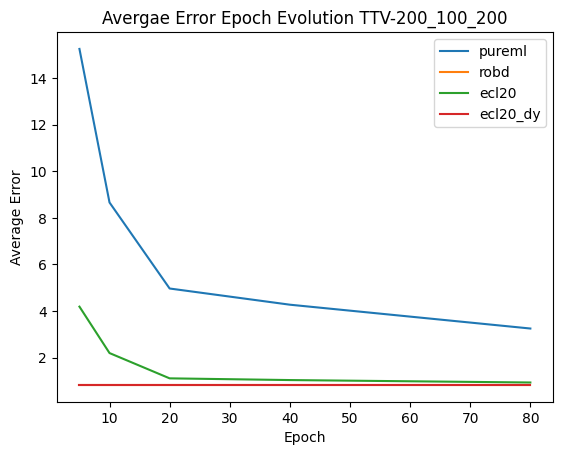

In [30]:
import matplotlib.pyplot as plt
plt.plot(d_100_f["epoch"][(d_100_f["type"] == "pureml")].values,d_100_f["average"][(d_100_f["type"] == "pureml")].values,label="pureml")
plt.plot(d_100_f["epoch"][(d_100_f["type"] == "robd")].values,d_100_f["average"][(d_100_f["type"] == "robd")].values,label="robd")
plt.plot(d_100_f["epoch"][(d_100_f["type"] == "ecl20")].values,d_100_f["average"][(d_100_f["type"] == "ecl20")].values,label="ecl20")
plt.plot(d_100_f_dy["epoch"][(d_100_f_dy["type"] == "ecl20")].values,d_100_f_dy["average"][(d_100_f_dy["type"] == "ecl20")].values,label="ecl20_dy")
plt.title('Avergae Error Epoch Evolution TTV-200_100_200')
plt.xlabel('Epoch')
plt.ylabel('Average Error')
plt.legend()
plt.savefig('result/fig/Av_Er_ttv_212_g.png')

In [23]:
import os
os.makedirs('result', exist_ok=True)

In [28]:
os.makedirs('result/fig', exist_ok=True)

In [24]:
d_100_f.to_csv('result/d_200_100_200_d_100_f')

In [25]:
d_100_f_dy.to_csv('result/d_200_100_200_d_100_f_dy')

In [8]:
df= pd.read_csv(csv_file, header = 2)

data_raws = load_power_shortage(df)

n_trian_step= 200 #24*60   #orginally 24*60 change for debugging to 10
n_val_step= 200 #  24*30    #originally 24*30 change for debugging to 10
n_test_step= 200 # 24*60

## Splitting training and testing dataset
data_raw = data_raws.reshape([-1,1])
train_raw=data_raw[:n_trian_step, :]
val_raw=data_raw[n_trian_step:n_trian_step+n_val_step, :]
test_raw = data_raw[n_trian_step + n_val_step:n_trian_step+n_val_step + n_test_step,:]


In [15]:
data_raws.tolist()

[0.742416291311215,
 0.7413122444253496,
 0.7387090383693738,
 0.7352929023501827,
 0.7319681886461973,
 0.7233431870127228,
 0.6779997314297252,
 0.5727368633512275,
 0.42926500490799246,
 0.2997174412832088,
 0.2287486773399777,
 0.22247213735236407,
 0.2532032967461568,
 0.3143174686929248,
 0.411539203533521,
 0.531953748712045,
 0.6440564038847973,
 0.7195941262683532,
 0.7516558514356881,
 0.755533449348844,
 0.7490833706723703,
 0.7414893552775169,
 0.7338673550476356,
 0.7269514048093407,
 0.7220963396355496,
 0.7202116046886825,
 0.7225940086034278,
 0.7294594008203691,
 0.7400555614664482,
 0.7497726261752294,
 0.7446238940840644,
 0.7113182948170519,
 0.6492849719811481,
 0.5720583215114599,
 0.500917523729141,
 0.453284417511458,
 0.43587226875338436,
 0.45218120605639245,
 0.5042774622632706,
 0.5837347962909579,
 0.669160335683298,
 0.7375164817594982,
 0.777025560694154,
 0.7922753564415873,
 0.7964521761950606,
 0.7976680823231364,
 0.7975455996845728,
 0.79665639319786

In [5]:
train_seq = sliding_windows(train_raw, seq_length)

In [7]:
train_seq.shape

(176, 25, 1)

In [4]:
xk = [1,2,3,4,5]
xk[:5]

[1, 2, 3, 4, 5]

In [5]:
for i in range(5):
    print(i)

0
1
2
3
4


In [9]:
train_seq[4:6,:,0]

array([[0.73196819, 0.72334319, 0.67799973, 0.57273686, 0.429265  ,
        0.29971744, 0.22874868, 0.22247214, 0.2532033 , 0.31431747,
        0.4115392 , 0.53195375, 0.6440564 , 0.71959413, 0.75165585,
        0.75553345, 0.74908337, 0.74148936, 0.73386736, 0.7269514 ,
        0.72209634, 0.7202116 , 0.72259401, 0.7294594 , 0.74005556],
       [0.72334319, 0.67799973, 0.57273686, 0.429265  , 0.29971744,
        0.22874868, 0.22247214, 0.2532033 , 0.31431747, 0.4115392 ,
        0.53195375, 0.6440564 , 0.71959413, 0.75165585, 0.75553345,
        0.74908337, 0.74148936, 0.73386736, 0.7269514 , 0.72209634,
        0.7202116 , 0.72259401, 0.7294594 , 0.74005556, 0.74977263]])

In [62]:
d_100_f_dy

,l,epoch,type,average,cr
0,0.0004,5,pureml,2821.401890,1.836013e+07
1,0.0004,5,robd,NaN,NaN
2,0.0004,5,mlrobd,NaN,NaN
3,0.0004,5,ecl20,NaN,NaN
4,0.0003,5,pureml,3504.790122,2.284573e+07
5,0.0003,5,robd,NaN,NaN
6,0.0003,5,mlrobd,NaN,NaN
7,0.0003,5,ecl20,NaN,NaN


In [ ]:
d_100_f = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 100
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_100_f.loc[len(d_100_f.index)] = [li, epoch_num, i["name"], avg, cr]

In [702]:
d_100_f

,l,epoch,type,average,cr
24,0.00003,100,ecl20,1.150339,47.837383


In [703]:
d_200_f = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 200
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_200_f.loc[len(d_200_f.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.8938315877099019 and cr is 3.0227549313720767 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd average is 0.7973111122256928 and cr is 1.1357791289986496 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
ecl20 average is 0.8807709284102437 and cr is 3.0161830654240673 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.8995869472668176 and cr is 3.0480017426887 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd averag

In [704]:
d_200_f

,l,epoch,type,average,cr
0,0.00040,200,pureml,0.893832,3.022755
1,0.00040,200,robd,0.809919,0.942096
2,0.00040,200,mlrobd,0.797311,1.135779
3,0.00040,200,ecl20,0.880771,3.016183
4,0.00030,200,pureml,0.899587,3.048002
5,0.00030,200,robd,0.809919,0.942096
6,0.00030,200,mlrobd,0.779988,1.135540
7,0.00030,200,ecl20,0.896948,2.975461
8,0.00020,200,pureml,0.906244,3.045023
9,0.00020,200,robd,0.809919,0.942096


In [705]:
d_300_f = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 300
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_300_f.loc[len(d_300_f.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.8879895160524349 and cr is 3.4118784678746823 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd average is 0.8139373804123465 and cr is 1.1551440846139218 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
ecl20 average is 0.8764325881989363 and cr is 2.9342386758500525 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.8877294666499884 and cr is 2.9900662846216877 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd ave

In [706]:
d_300_f

,l,epoch,type,average,cr
0,0.00040,300,pureml,0.887990,3.411878
1,0.00040,300,robd,0.809919,0.942096
2,0.00040,300,mlrobd,0.813937,1.155144
3,0.00040,300,ecl20,0.876433,2.934239
4,0.00030,300,pureml,0.887729,2.990066
5,0.00030,300,robd,0.809919,0.942096
6,0.00030,300,mlrobd,0.814953,1.188989
7,0.00030,300,ecl20,0.876615,2.832404
8,0.00020,300,pureml,0.903449,3.007170
9,0.00020,300,robd,0.809919,0.942096


In [707]:
d_600_f = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 600
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_600_f.loc[len(d_600_f.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.8570696482117616 and cr is 2.6295421386941347 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd average is 0.7881918031079612 and cr is 1.0945003184898334 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
ecl20 average is 0.8577430540244044 and cr is 2.944423997732994 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
pureml average is 0.881628441809137 and cr is 3.5386148690427497 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
robd average is 0.8099187530924316 and cr is 0.9420964025190998 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([5976, 25, 1])
mlrobd avera

In [708]:
d_600_f

,l,epoch,type,average,cr
0,0.00040,600,pureml,0.857070,2.629542
1,0.00040,600,robd,0.809919,0.942096
2,0.00040,600,mlrobd,0.788192,1.094500
3,0.00040,600,ecl20,0.857743,2.944424
4,0.00030,600,pureml,0.881628,3.538615
5,0.00030,600,robd,0.809919,0.942096
6,0.00030,600,mlrobd,0.801304,1.167260
7,0.00030,600,ecl20,0.863195,2.927116
8,0.00020,600,pureml,0.884165,3.177619
9,0.00020,600,robd,0.809919,0.942096


In [712]:
#full data set
d_300_full = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 300
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_300_full.loc[len(d_300_full.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
pureml average is 6.048049597374685 and cr is 33554.96530796144 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
robd average is 0.8112857512319713 and cr is 0.9986957214274039 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
mlrobd average is 1.9767908528365783 and cr is 7721.367730739285 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
ecl20 average is 4.558575163398956 and cr is 23979.658485885317 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
pureml average is 9.5860372697413 and cr is 56684.974640060034 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
robd average is 0.8112857512319713 and cr is 0.9986957214274039 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
mlrobd average is

In [713]:
d_300_full

,l,epoch,type,average,cr
0,0.00040,300,pureml,6.048050,3.355497e+04
1,0.00040,300,robd,0.811286,9.986957e-01
2,0.00040,300,mlrobd,1.976791,7.721368e+03
3,0.00040,300,ecl20,4.558575,2.397966e+04
4,0.00030,300,pureml,9.586037,5.668497e+04
5,0.00030,300,robd,0.811286,9.986957e-01
6,0.00030,300,mlrobd,1.946131,7.428899e+03
7,0.00030,300,ecl20,8.517902,4.979793e+04
8,0.00020,300,pureml,13.416904,8.160459e+04
9,0.00020,300,robd,0.811286,9.986957e-01


In [717]:
#full data set
d_50_train = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])

epoch_num = 50
for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [pureml, robd, mlrobd, ecl20]:
        [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epoch_num, li )
        print(f'{i["name"]} average is {avg} and cr is {cr} learning_rate is {li}')
        d_50_train.loc[len(d_50_train.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
pureml average is 1.1201799720313506 and cr is 2.4606968147569535 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
robd average is 0.8250489391628185 and cr is 0.927491143950123 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
mlrobd average is 0.8398174728484007 and cr is 1.0380851992993039 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
ecl20 average is 1.1319105474606233 and cr is 3.4289271741189795 learning_rate is 0.0004
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
pureml average is 1.1702564063426901 and cr is 2.7502351401704055 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
robd average is 0.8250489391628185 and cr is 0.927491143950123 learning_rate is 0.0003
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
mlrobd avera

In [718]:
d_50_train

,l,epoch,type,average,cr
0,0.00040,50,pureml,1.120180,2.460697
1,0.00040,50,robd,0.825049,0.927491
2,0.00040,50,mlrobd,0.839817,1.038085
3,0.00040,50,ecl20,1.131911,3.428927
4,0.00030,50,pureml,1.170256,2.750235
5,0.00030,50,robd,0.825049,0.927491
6,0.00030,50,mlrobd,0.864258,1.210791
7,0.00030,50,ecl20,1.107136,2.160228
8,0.00020,50,pureml,1.936702,19.927559
9,0.00020,50,robd,0.825049,0.927491


In [723]:
from utils.model import LSTM_unroll_dynamic
#torch.set_default_dtype(torch.torch.float64)
d_50_train_dyn = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])
epochoneh = 50

for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [mlrobd, ecl20]:
#for i in [ecl20]:
          [avg, cr] = replication_dynamic(i, csv_file,optimal_train_cost_array, train_raw, epochoneh,li )
          print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr} learning rate is {li}')
          d_50_train_dyn.loc[len(d_50_train_dyn.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
torch.Size([1416, 25, 1])
mlrobd  train 50 epoch average is 5.874371575414952 and cr is 245.50268480263875 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
torch.Size([1416, 25, 1])
ecl20  train 50 epoch average is 6.494944530095782 and cr is 188.18319688781457 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
torch.Size([1416, 25, 1])
mlrobd  train 50 epoch average is 5.5597464814728 and cr is 161.59054012939194 learning rate is 0.0003
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
torch.Size([1416, 25, 1])
ecl20  train

In [725]:
d_50_train_dyn

,l,epoch,type,average,cr
0,0.00040,50,mlrobd,5.874372,245.502685
1,0.00040,50,ecl20,6.494945,188.183197
2,0.00030,50,mlrobd,5.559746,161.590540
3,0.00030,50,ecl20,6.039342,214.884435
4,0.00020,50,mlrobd,5.140512,164.485278
5,0.00020,50,ecl20,3.754503,153.624983
6,0.00010,50,mlrobd,5.159481,170.674857
7,0.00010,50,ecl20,3.757136,92.288160
8,0.00006,50,mlrobd,4.205976,109.140235
9,0.00006,50,ecl20,3.753584,96.277374


In [727]:
from utils.model import LSTM_unroll_dynamic
#torch.set_default_dtype(torch.torch.float64)
d_50_train_dynb = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])
epochoneh = 50

for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [mlrobd, ecl20, ecl20b]:
#for i in [ecl20]:
          [avg, cr] = replication_dynamic(i, csv_file,optimal_train_cost_array, train_raw, epochoneh,li )
          print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr} learning rate is {li}')
          d_50_train_dynb.loc[len(d_50_train_dynb.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
mlrobd  train 50 epoch average is 5.723257123618971 and cr is 169.14176048516097 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
ecl20  train 50 epoch average is 6.272933559838649 and cr is 162.98471296540487 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
ecl20  train 50 epoch average is 6.574235112134313 and cr is 266.4390362781326 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
mlrobd  train 50 epoch average is 5.446610670993105 and cr is 188.2887404694237 learning rate is 0.0003
Calculating 

In [728]:
d_50_train_dynb


,l,epoch,type,average,cr
0,0.00040,50,mlrobd,5.723257,169.141760
1,0.00040,50,ecl20,6.272934,162.984713
2,0.00040,50,ecl20,6.574235,266.439036
3,0.00030,50,mlrobd,5.446611,188.288740
4,0.00030,50,ecl20,5.811491,167.281445
5,0.00030,50,ecl20,4.941583,200.909081
6,0.00020,50,mlrobd,5.101128,124.857284
7,0.00020,50,ecl20,4.647185,109.664667
8,0.00020,50,ecl20,5.584225,222.995158
9,0.00010,50,mlrobd,4.220267,157.143581


In [732]:
from utils.model import LSTM_unroll_dynamic
#torch.set_default_dtype(torch.torch.float64)
d_50_train_dynbp = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])
epochoneh = 50

for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [mlrobd, ecl20, ecl20b]:
#for i in [ecl20]:
          [avg, cr] = replication_dynamic(i, csv_file,optimal_train_cost_array, train_raw, epochoneh,li )
          print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr} learning rate is {li}')
          d_50_train_dynbp.loc[len(d_50_train_dynbp.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
mlrobd  train 50 epoch average is 5.673392477657553 and cr is 215.5309521202652 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
ecl20  train 50 epoch average is 5.317759713739434 and cr is 186.53987120219446 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
ecl20b  train 50 epoch average is 5.624778220962912 and cr is 144.17682125129565 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
mlrobd  train 50 epoch average is 5.658520899679909 and cr is 214.72427832011448 learning rate is 0.0003
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values .

In [733]:
d_50_train_dynbp


,l,epoch,type,average,cr
0,0.00040,50,mlrobd,5.673392,215.530952
1,0.00040,50,ecl20,5.317760,186.539871
2,0.00040,50,ecl20b,5.624778,144.176821
3,0.00030,50,mlrobd,5.658521,214.724278
4,0.00030,50,ecl20,5.444401,134.897058
5,0.00030,50,ecl20b,5.160396,139.733239
6,0.00020,50,mlrobd,5.731983,239.569310
7,0.00020,50,ecl20,4.805341,177.373373
8,0.00020,50,ecl20b,4.970304,260.403607
9,0.00010,50,mlrobd,4.969397,143.303837


In [731]:
from utils.model import LSTM_unroll_dynamic
#torch.set_default_dtype(torch.torch.float64)
d_100_train_dynb = pd.DataFrame(columns=['l', 'epoch', 'type', 'average', 'cr'])
epochoneh = 100

for li in [4e-4, 3e-4, 2e-4, 1e-4, 6e-5, 3e-5]:
    for i in [mlrobd, ecl20, ecl20b]:
#for i in [ecl20]:
          [avg, cr] = replication_dynamic(i, csv_file,optimal_train_cost_array, train_raw, epochoneh,li )
          print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr} learning rate is {li}')
          d_100_train_dynb.loc[len(d_100_train_dynb.index)] = [li, epoch_num, i["name"], avg, cr]

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
mlrobd  train 100 epoch average is 5.348140957631662 and cr is 137.29084881792735 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
ecl20  train 100 epoch average is 6.452113240792106 and cr is 156.44364126834307 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
ecl20b  train 100 epoch average is 6.4683701279958665 and cr is 138.3829004963445 learning rate is 0.0004
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
mlrobd  train 100 epoch average is 5.92617849605034 and cr is 250.23543178532384 learning rate is 0.0003
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal valu

In [540]:
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_val_cost_array, val_raw, 25 )
    print(f'{i["name"]} average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
tensor(8.2260, dtype=torch.float64, grad_fn=<MaxBackward1>)
pureml average is 2.7401281670921485 and cr is 8.22604611442949
Calculating Offline Optimal values ...
tensor(2.1777, dtype=torch.float64, grad_fn=<MaxBackward1>)
robd average is 1.4324682896651915 and cr is 2.177681586431589
Calculating Offline Optimal values ...
tensor(2.3288, dtype=torch.float64, grad_fn=<MaxBackward1>)
mlrobd average is 1.717519115969602 and cr is 2.328751509059642
Calculating Offline Optimal values ...
tensor(2.4673, dtype=torch.float64, grad_fn=<MaxBackward1>)
ecl20 average is 1.7500461327369157 and cr is 2.4672558581571566


In [541]:
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_val_cost_array, val_raw, 25 )
    print(f'{i["name"]} average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
tensor(8.7564, dtype=torch.float64, grad_fn=<MaxBackward1>)
pureml average is 2.7754026286821767 and cr is 8.75642543190183
Calculating Offline Optimal values ...
tensor(2.5677, dtype=torch.float64, grad_fn=<MaxBackward1>)
robd average is 1.7551081859341624 and cr is 2.5677346918512107
Calculating Offline Optimal values ...
tensor(2.7930, dtype=torch.float64, grad_fn=<MaxBackward1>)
mlrobd average is 1.3827938822067467 and cr is 2.7930306541885255
Calculating Offline Optimal values ...
tensor(2.3837, dtype=torch.float64, grad_fn=<MaxBackward1>)
ecl20 average is 1.593419592337204 and cr is 2.383661698049754


In [542]:
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_val_cost_array, val_raw, 50 )
    print(f'{i["name"]} average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
tensor(3.3068, dtype=torch.float64, grad_fn=<MaxBackward1>)
pureml average is 2.1097329463239527 and cr is 3.30684960634626
Calculating Offline Optimal values ...
tensor(2.9129, dtype=torch.float64, grad_fn=<MaxBackward1>)
robd average is 1.8629408222244024 and cr is 2.912933415319756
Calculating Offline Optimal values ...
tensor(2.6530, dtype=torch.float64, grad_fn=<MaxBackward1>)
mlrobd average is 1.8483723794289935 and cr is 2.6529708759577257
Calculating Offline Optimal values ...
tensor(2.6588, dtype=torch.float64, grad_fn=<MaxBackward1>)
ecl20 average is 1.7979034645049519 and cr is 2.658830207543743


In [544]:
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, 50 )
    print(f'{i["name"]} 50 epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
pureml 50 epoch average is 2.3769651074711193 and cr is 39.38110677133128
Calculating Offline Optimal values ...
robd 50 epoch average is 1.8364813018604629 and cr is 9.805922159625766
Calculating Offline Optimal values ...
mlrobd 50 epoch average is 1.818309686290396 and cr is 3.993209317809692
Calculating Offline Optimal values ...
ecl20 50 epoch average is 1.8462634962160833 and cr is 5.988158665680206


In [545]:
epochsf = 75
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochsf )
    print(f'{i["name"]} {epochsf} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
pureml 75 epoch average is 1.8968772131443066 and cr is 9.072958120873034
Calculating Offline Optimal values ...
robd 75 epoch average is 1.8085046812206462 and cr is 10.390009614640878
Calculating Offline Optimal values ...
mlrobd 75 epoch average is 1.817919755931115 and cr is 4.053155866754866
Calculating Offline Optimal values ...
ecl20 75 epoch average is 1.8301863287732218 and cr is 5.995542560232868


In [546]:
epochoneh = 100
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochoneh )
    print(f'{i["name"]} {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
pureml 100 epoch average is 1.841200064790229 and cr is 6.667841776306407
Calculating Offline Optimal values ...
robd 100 epoch average is 1.8447130102332174 and cr is 6.009754916064146
Calculating Offline Optimal values ...
mlrobd 100 epoch average is 1.7916766150973087 and cr is 3.94981787716925
Calculating Offline Optimal values ...
ecl20 100 epoch average is 1.8044394722326744 and cr is 5.717748858985553


In [553]:
epochoneh = 100
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochoneh )
    print(f'{i["name"]} {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
pureml 100 epoch average is 1.88164060385633 and cr is 6.340537059546677
Calculating Offline Optimal values ...
robd 100 epoch average is 1.7808386007036399 and cr is 5.775477956180453
Calculating Offline Optimal values ...
mlrobd 100 epoch average is 1.7888289491475589 and cr is 3.8923719196495057
Calculating Offline Optimal values ...
ecl20 100 epoch average is 1.8415546020990514 and cr is 5.79936392020997


In [631]:
#full test data
from utils.model import LSTM_unroll
epochoneh = 100
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochoneh )
    print(f'{i["name"]} {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
pureml 100 epoch average is 28.97424214699449 and cr is 183019.30067445163
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
robd 100 epoch average is 11.317801606971052 and cr is 67905.93790253633
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
mlrobd 100 epoch average is 5.437911979824143 and cr is 29486.47553653676
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
ecl20 100 epoch average is 12.755191631738247 and cr is 77176.82507473388


In [632]:
#full test data
from utils.model import LSTM_unroll
epochoneh = 150
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochoneh )
    print(f'{i["name"]} {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
pureml 150 epoch average is 15.389990823352996 and cr is 94508.98528934142
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
robd 150 epoch average is 10.320543708294512 and cr is 61442.894426320825
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
mlrobd 150 epoch average is 3.45057948900861 and cr is 16587.858477494316
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
ecl20 150 epoch average is 6.5359188234463215 and cr is 36860.96369140468


In [640]:
#full test data
from utils.model import LSTM_unroll
epochoneh = 200
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_test_cost_array, test_raw, epochoneh )
    print(f'{i["name"]} {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
pureml 200 epoch average is 12.529346678552558 and cr is 75891.57955016222
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
robd 200 epoch average is 9.265000658539515 and cr is 54683.17891797071
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
mlrobd 200 epoch average is 2.934397738869918 and cr is 13265.517572890396
Calculating Offline Optimal values ...
torch.Size([6576, 25, 1])
ecl20 200 epoch average is 9.27336180986977 and cr is 54642.57022902597


In [555]:
epochsf = 75
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochsf )
    print(f'{i["name"]}  train {epochsf} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
pureml  train 75 epoch average is 2.238486674308768 and cr is 4.914938882586329
Calculating Offline Optimal values ...
robd  train 75 epoch average is 2.084454008061301 and cr is 4.511723055406309
Calculating Offline Optimal values ...
mlrobd  train 75 epoch average is 2.0273288518663413 and cr is 3.3948344582478382
Calculating Offline Optimal values ...
ecl20  train 75 epoch average is 2.038766901879836 and cr is 4.704657770653352


In [651]:
"""
epochoneh = 100
for i in [pureml, robd, mlrobd, ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')
"""

'\nepochoneh = 100\nfor i in [pureml, robd, mlrobd, ecl20]:\n    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )\n    print(f\'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}\')\n'

In [565]:
from utils.model import LSTM_unroll
epochoneh = 2
for i in [ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
ecl20  train 2 epoch average is 5.077886400165566 and cr is 96.71596939446702


In [568]:
from utils.model import LSTM_unroll_dynamic
from utils.traincrs import train_cr_vals_dynamic

In [46]:
def replication_dynamic(input_dict, csv_file, op_val_cost_array, temp_raw , epoch_number=25, lr=4e-4):
    l_1 = input_dict["l1"]
    l_2 = input_dict["l2"]
    l_3 = input_dict["l3"]
    n_iter = 0
    n_iter_val = 0
    epoch_num = epoch_number
    batch_size = 50
    #print("Parameters")
    #print("     w     l_1     l_2     l_3     mtl     ")
    #print("  {:.3f}   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(w, l_1, l_2, l_3, mtl_weight))

    hidden_size = 10
    num_classes = 1

    input_size = 2 * num_classes
    seq_length = 25
    num_layers = 3
    mtl_weight = 0.5
    # df_header = pd.read_csv(csv_file, nrows=1) ## general information (e.g. time zone, elevation)
    df= pd.read_csv(csv_file, header = 2)

    data_raws = load_power_shortage(df)

    n_trian_step= 200 #24*60   #orginally 24*60 change for debugging to 10
    n_val_step= 200 #  24*30    #originally 24*30 change for debugging to 10
    # n_test_step=24*60

    ## Splitting training and testing dataset
    data_raw = data_raws.reshape([-1,1])
    train_raw=data_raw[:n_trian_step, :]
    val_raw=data_raw[n_trian_step:n_trian_step+n_val_step, :]
    print(f'train raw is {train_raw.size}') 
    train_seq = sliding_windows(train_raw, seq_length)
    val_seq = sliding_windows(val_raw, seq_length)
    temp_seq = sliding_windows(temp_raw, seq_length)
    bsize = temp_seq.shape[0]
    #print(f'bsize is {bsize}')

    print(f'train_seq is {train_seq.size}')
    traject_dataset_train = TrajectCR_Dataset(train_seq, w, mute=mute)
    train_dataloader = DataLoader(traject_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

    traject_dataset_val = TrajectCR_Dataset(val_seq, w, mute=mute)
    val_dataloader = DataLoader(traject_dataset_val, batch_size=batch_size, shuffle=True, num_workers=4)

    traject_dataset_temp = TrajectCR_Dataset(temp_seq, w, mute=mute)
    temp_dataloader = DataLoader(traject_dataset_temp, batch_size=bsize, shuffle=True, num_workers=4)

    val_seq = val_raw.reshape([1,-1,1])
    val_seq_tensor = torch.from_numpy(val_seq).float()
    if use_cuda: val_seq_tensor = val_seq_tensor.cuda()

    lstm = LSTM_unroll_dynamic(num_classes, input_size, hidden_size, num_layers, 
                        seq_length, w, l_1, l_2, l_3)

    optimizer = optim.Adam(lstm.parameters(), lr=lr)
    if use_cuda: lstm = lstm.cuda()
    writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
    writer = SummaryWriter(writer_path)
    #del train_cr
    #from train_unroll_batch import train_cr

    #train_cr_vals(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
    #            epoch_num, pureml["c"], min_cr, mtl_weight=pureml["mtl_weight"], mute=mute, l_1=pureml["l1"],l_2=pureml["l2"], l_3=pureml["l3"], calib=pureml["calib"])

    train_cr_vals_dynamic(lstm, optimizer, writer, train_dataloader, val_dataloader, op_val_cost_array,
            epoch_num, input_dict["c"], min_cr, mtl_weight=input_dict["mtl_weight"], mute=mute, l_1=input_dict["l1"],l_2=input_dict["l2"], l_3=input_dict["l3"], calib=input_dict["traincalib"])
    temp_seq = sliding_windows(temp_raw, seq_length)
    #temp_seq.shape
    temp_action_seq = torch.zeros(temp_seq.shape)
    temp_action_seq.shape
    lstm.eval()
    for _, (demand,opt_cost) in enumerate(temp_dataloader):
            demand = demand.float()
            
            opt_cost = torch.reshape(opt_cost, (opt_cost.shape[0], 1))
            #opt_cost = np.expand_dims(opt_cost, axis=1)
            #opt_cost = opt_cost.float()
            if use_cuda: 
                demand = demand.cuda()
                opt_cost = opt_cost.cuda()
            #print(demand.shape)
            #print(opt_cost.shape)
            # zero the parameter gradients
            #optimizer.zero_grad()
            #demand = demand.type('torch.FloatTensor')
            #opt_cost = opt_cost.type('torch.FloatTensor')
            #action_ml = ml_model(demand, torch.from_numpy(opt_cost).float(), calib = calib)
            tmval = lstm(demand, opt_cost, calib = input_dict['testcalib'])
    #tmval = lstm(torch.from_numpy(temp_seq).float(), torch.from_numpy(op_val_cost_array).float(),mode="val", calib=input_dict["testcalib"])
    #tmval = lstm(temp_dataloader,mode="val", calib=input_dict["testcalib"])
    #print(tmval.shape)
    #print(torch.max(tmval))
    hit_cost = torch.norm(tmval - torch.from_numpy(temp_seq).float(), dim=1)
    hit_cost = (1/2)*(hit_cost)**2
    #print(torch.max(hit_cost))

    #switch_diff = action[:,1:,:] - action[:,:-1,:]
    switch_cost = torch.norm(tmval[:,1:,:] - tmval[:,:-1,:], dim=1)
    switch_cost = (10/2)*(switch_cost)**2
    #print(switch_cost.shape)
    val_cost_norm = hit_cost + switch_cost
    norm_cost = torch.div(val_cost_norm, torch.from_numpy(op_val_cost_array).unsqueeze(1))
    #print(torch.max(norm_cost))
    average_cost_value = torch.mean(norm_cost).item()
    cr_value = torch.max(norm_cost).item()
    return [average_cost_value, cr_value]


In [610]:
torch.set_default_dtype(torch.torch.float32)


In [668]:
from utils.model import LSTM_unroll

epochoneh = 2
for i in [mlrobd]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
mlrobd  train 2 epoch average is 1.8549684843945942 and cr is 33.43974488824863


In [669]:
from utils.model import LSTM_unroll

epochoneh = 2
for i in [robd]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
robd  train 2 epoch average is 2.459152949314517 and cr is 46.192028601761955


In [611]:
from utils.model import LSTM_unroll

epochoneh = 1
for i in [ecl20]:
    [avg, cr] = replication(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
ecl20  train 1 epoch average is 10.060731081399107 and cr is 185.8526546295215


In [667]:
from utils.model import LSTM_unroll_dynamic
#torch.set_default_dtype(torch.torch.float64)
epochoneh = 2
for i in [ecl20]:
    [avg, cr] = replication_dynamic(i, csv_file,optimal_train_cost_array, train_raw, epochoneh )
    print(f'{i["name"]}  train {epochoneh} epoch average is {avg} and cr is {cr}')

Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
Calculating Offline Optimal values ...
torch.Size([1416, 25, 1])
torch.Size([1416, 25, 1])
ecl20  train 2 epoch average is 3.972835243355751 and cr is 109.07469255051207


In [714]:
test_raw=data_raw[n_trian_step+n_val_step:8700,:]
test_raw.shape

(6540, 1)

In [13]:
test_raw.shape

(6600, 1)

In [15]:
seq_length = 25
tt = sliding_windows(test_raw, seq_length)
tt.shape

(6576, 25, 1)

In [19]:
sample_seq = tt[1,:,:]
optimal_action, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=10)

In [21]:
optimal_action.shape


(25,)

In [627]:
#torch.topk(torch.from_numpy(optimal_test_cost_array).float(), 10, largest=False)

In [26]:
from utils.solution import calculate_offline_optimal

In [34]:
test_seq = sliding_windows(test_raw, seq_length)

In [35]:
num_test_seq = test_seq.shape[0]
optimal_test_cost_array = np.zeros(num_test_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_test_list = range(num_test_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_test_list:
    sample_seq = test_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_test_cost_array[i] = optimal_cost

In [42]:
test_seq[1,:,:][0].shape

(1,)

In [66]:
tts = test_seq[1,:,:]
tts.shape
tts[1:]

array([[0.78947308],
       [0.788123  ],
       [0.7825249 ],
       [0.75837145],
       [0.70623043],
       [0.63829379],
       [0.57022728],
       [0.50317757],
       [0.4103418 ],
       [0.28230551],
       [0.14847717],
       [0.05195708],
       [0.00767274],
       [0.01286359],
       [0.08932048],
       [0.25487154],
       [0.47025824],
       [0.65841527],
       [0.76194093],
       [0.78712951],
       [0.78697531],
       [0.78647361],
       [0.78856592],
       [0.79217442]])

In [36]:
train_seq = sliding_windows(train_raw, seq_length)
num_test_seq = train_seq.shape[0]
optimal_train_cost_array = np.zeros(num_test_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_test_list = range(num_test_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_test_list:
    sample_seq = train_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_train_cost_array[i] = optimal_cost

In [37]:
val_seq = sliding_windows(val_raw, seq_length)

num_val_seq = val_seq.shape[0]
optimal_val_cost_array = np.zeros(num_val_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_val_list = range(num_val_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_val_list:
    sample_seq = val_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_val_cost_array[i] = optimal_cost

In [462]:
replication(pureml, csv_file,optimal_val_cost_array )

Calculating Offline Optimal values ...


[2.996326069443749, 9.500739157313685]

In [479]:
replication(pureml, csv_file,optimal_val_cost_array, val_raw )

Calculating Offline Optimal values ...


[3.015288721696174, 10.694017756642848]

In [513]:
replication(pureml, csv_file,optimal_test_cost_array, test_raw )

Calculating Offline Optimal values ...
torch.Size([5816, 25, 1])
tensor(0.8382, grad_fn=<MaxBackward1>)
tensor(1.0381, grad_fn=<MaxBackward1>)
torch.Size([5816, 1])
tensor(78.2914, dtype=torch.float64, grad_fn=<MaxBackward1>)


[3.077022074203832, 78.29138966604039]

In [526]:
replication(mlrobd, csv_file,optimal_val_cost_array, val_raw )

Calculating Offline Optimal values ...
torch.Size([696, 25, 1])
tensor(0.7998, grad_fn=<MaxBackward1>)
tensor(0.2045, grad_fn=<MaxBackward1>)
torch.Size([696, 1])
tensor(2.4720, dtype=torch.float64, grad_fn=<MaxBackward1>)


[1.7574105155992437, 2.472034369862605]

In [461]:
replication(robd, csv_file, optimal_val_cost_array)

Calculating Offline Optimal values ...


[1.7896645200925512, 3.0830523360338282]

In [474]:
replication(ecl20, csv_file, optimal_val_cost_array)

Calculating Offline Optimal values ...


[1.500775825356932, 2.61384382691029]

In [522]:
replication(ecl20, csv_file, optimal_test_cost_array, test_raw)

Calculating Offline Optimal values ...
torch.Size([5816, 25, 1])
tensor(0.8215, grad_fn=<MaxBackward1>)
tensor(0.3363, grad_fn=<MaxBackward1>)
torch.Size([5816, 1])
tensor(19.7692, dtype=torch.float64, grad_fn=<MaxBackward1>)


[1.7590011657624767, 19.76915478352493]

In [523]:
replication(mlrobd, csv_file, optimal_test_cost_array, test_raw)

Calculating Offline Optimal values ...
torch.Size([5816, 25, 1])
tensor(0.8015, grad_fn=<MaxBackward1>)
tensor(0.1632, grad_fn=<MaxBackward1>)
torch.Size([5816, 1])
tensor(10.9269, dtype=torch.float64, grad_fn=<MaxBackward1>)


[1.8694502143514458, 10.92690161326527]

In [318]:
#del train_cr
import train_unroll_batch
from train_unroll_batch import train_cr
train_cr

<function train_unroll_batch.train_cr(ml_model, optimizer, writer, train_dataloader, demand_validation, num_epoch, switch_weight, min_cr, mtl_weight=0.5, mute=True)>

In [290]:
optimizer = optim.Adam(lstm.parameters(), lr=4e-4)
if use_cuda: lstm = lstm.cuda()

from train_unroll_batch import train_cr

train_cr(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
            epoch_num, w, min_cr, mtl_weight = mtl_weight, mute=mute)

In [291]:
writer_path = base_log_dir + "/mtl_{:.2f}/".format(mtl_weight)
writer = SummaryWriter(writer_path)

In [292]:
from train_unroll_batch import train_cr

In [293]:
train_cr(lstm, optimizer, writer, train_dataloader, val_seq_tensor, 
            epoch_num, w, min_cr, mtl_weight = mtl_weight, mute=mute)

In [294]:
val_seq = sliding_windows(val_raw, seq_length)
val_seq.shape
val_action_seq = torch.zeros(val_seq.shape)
val_action_seq.shape

torch.Size([696, 25, 1])

In [295]:
lstm.eval()
tmval = lstm(torch.from_numpy(val_seq).float(), mode="val", calib=True)

In [296]:
hitcostnum = tmval[:,:-1,:] - torch.from_numpy(val_seq[:,1:,:])
hitcost_norm = (1/2)*hitcostnum.norm(p=2, dim=1)
hitcost_norm.shape
hitcost = torch.square(hitcost_norm)

In [297]:
switchcostnum = torch.cat((torch.from_numpy(val_seq[:,0:1,:]),tmval[:,:-1,:]),1)
switchcost_norm = switchcostnum.norm(p=2,dim=1)
switchcost_norm = switchcost_norm*(1/2)
switchcost = torch.square(switchcost_norm)


In [298]:
val_cost_norm = hitcost + switchcost
average_cost = torch.mean(val_cost_norm)
average_cost

tensor(1.2616, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [299]:
norm_cost = torch.div(val_cost_norm, torch.from_numpy(optimal_val_cost_array).unsqueeze(1))
torch.mean(norm_cost)
torch.max(norm_cost)

In [ ]:
print(f'average cost is {torch.mean(norm_cost)} and CR is {torch.max(norm_cost)} ')

In [300]:
torch.mean(norm_cost)

tensor(1.9144, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [301]:
torch.max(norm_cost)

tensor(8.4984, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [255]:
switchcost_norm[1:10,0]

tensor([24.3613, 24.4407, 24.5062, 24.5169, 24.3035, 23.8985, 23.6413, 23.7345,
        24.0228], dtype=torch.float64, grad_fn=<SelectBackward>)

In [150]:
val_raw.shape

(720, 1)

In [151]:
val_seq_tensor.shape

torch.Size([1, 720, 1])

In [222]:
#lstm.eval()
#tmpp = lstm(val_seq_tensor, mode="val", calib=False)
#tmppcalib = lstm(val_seq, mode = "val", calib=True)


In [259]:
optimal_val_cost_array[1:10]

array([1.08767403, 1.11025187, 1.14255171, 1.17757263, 1.13469418,
       0.95516664, 0.75727616, 0.69073499, 0.72902481])

In [31]:
val_seq = sliding_windows(val_raw, seq_length)

In [29]:
from utils.solution import calculate_offline_optimal

In [32]:
num_val_seq = val_seq.shape[0]
optimal_val_cost_array = np.zeros(num_val_seq)
        
#print("Calculating Offline Optimal values ...")
#if mute:
seq_val_list = range(num_val_seq)
#else:
#    seq_list = tqdm(range(num_seq))
for i in seq_val_list:
    sample_seq = val_seq[i,:,:]
    _, optimal_cost = calculate_offline_optimal(sample_seq[1:], sample_seq[0], switch_weight=w)
    optimal_val_cost_array[i] = optimal_cost

In [215]:
val_seq_torch = torch.from_numpy(val_seq).float()[1,:,:].unsqueeze(0)

In [228]:
val_seq.shape

(696, 25, 1)

In [219]:
optimal_val_cost_array.shape

(696,)

In [213]:
val_seq_torch.shape

torch.Size([1, 25, 1])

In [231]:
lstm.eval()
tmval = lstm(torch.from_numpy(val_seq).float(), mode="val", calib=True)

In [232]:
tmval.shape

torch.Size([696, 25, 1])

In [221]:
tmval[:,:-1,:] - val_seq_torch[:,1:,:]

tensor([[[ 0.0046],
         [-0.1130],
         [-0.1252],
         [-0.0647],
         [ 0.0562],
         [ 0.1886],
         [ 0.2729],
         [ 0.2835],
         [ 0.2502],
         [ 0.2244],
         [ 0.2159],
         [ 0.2136],
         [ 0.1973],
         [ 0.1191],
         [-0.0201],
         [-0.1624],
         [-0.2428],
         [-0.2408],
         [-0.1978],
         [-0.1707],
         [-0.1623],
         [-0.1621],
         [-0.1640],
         [-0.1645]]], grad_fn=<SubBackward0>)

In [218]:
tmval

tensor([[[0.7236],
         [0.5967],
         [0.5626],
         [0.5516],
         [0.5284],
         [0.4739],
         [0.3927],
         [0.3098],
         [0.2513],
         [0.2244],
         [0.2159],
         [0.2136],
         [0.2131],
         [0.2188],
         [0.2505],
         [0.3214],
         [0.4200],
         [0.5154],
         [0.5793],
         [0.6075],
         [0.6170],
         [0.6205],
         [0.6229],
         [0.6253],
         [0.6271]]], grad_fn=<CatBackward>)

In [164]:
vmm = val_seq_tensor[:,0:20,:]

In [212]:
val_seq_tensor.shape

torch.Size([1, 720, 1])

In [197]:
tmppcalib = lstm(vmm, mode = "val", calib=True)

In [167]:
tmppcalib[0,1:10,0]

tensor([0.5995, 0.5668, 0.5608, 0.5567, 0.5341, 0.4786, 0.3963, 0.3124, 0.2531],
       grad_fn=<SelectBackward>)

In [182]:
train_raw.shape

(1440, 1)

In [183]:
train_seq.shape

(1416, 25, 1)

In [181]:
traject_dataset_train.__len__()

1416

In [169]:
inputs = [torch.randn(1, 3) for _ in range(5)] 
inputs = torch.cat(inputs)
inputs.shape


torch.Size([5, 3])

In [170]:
inp = inputs.view(len(inputs), 1, -1)
inp.shape

torch.Size([5, 1, 3])

In [171]:
inputs

tensor([[-0.8814,  1.7408,  0.9870],
        [ 0.6139, -1.2321, -0.5858],
        [-1.1450,  0.3239, -0.2196],
        [-0.0786,  1.4658,  0.7444],
        [-0.4457, -0.5515,  0.2068]])

In [172]:
inp

tensor([[[-0.8814,  1.7408,  0.9870]],

        [[ 0.6139, -1.2321, -0.5858]],

        [[-1.1450,  0.3239, -0.2196]],

        [[-0.0786,  1.4658,  0.7444]],

        [[-0.4457, -0.5515,  0.2068]]])

In [173]:
train_dataloader

In [175]:
train_dataloader.__sizeof__()

32

In [177]:
train_dataloader.batch_size

50

In [176]:
train_seq.shape

(1416, 25, 1)

In [179]:
train_dataloader.__len__()

29